# Experiments with real data (German Credit)

https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

## Requirements

In [50]:
import os, pickle
import polars as pl
import numpy as np
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix, ecdfplot_matrix

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', '..', 'data')
data_filename = 'uci_german_credit_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

## Data exploration


### Conceptual description

| Variable              | Descripción                                    | Tipo                  | Valores                                                                 |
| --------------------- | ---------------------------------------------- | --------------------- | ----------------------------------------------------------------------- |
| credit-risk           | Etiqueta binaria del comportamiento crediticio | Binaria               | `good (1)`, `bad (0)`                                                   |
| checking_status       | Estado de la cuenta corriente del solicitante  | Categórica ordinal    | `no checking (0)`, `<0 (1)`, `0<=X<200 (2)`, `>=200 (3)`                |
| duration              | Duración del crédito en meses                  | Numérica (discreta)   | 6, 12, 24, 48, 60, ...                                                  |
| credit_history        | Historial crediticio previo del solicitante    | Categórica nominal    | `all paid (0)`, `critical/other existing credit (1)`, `delayed previously (2)`, `existing paid (3)`, `no credits/all paid (4)` |
| purpose               | Finalidad declarada del crédito                | Categórica nominal    | `business (0)`, `domestic appliance (1)`, `education (2)`, `furniture/equipment (3)`, `new car (4)`, `other (5)`, `radio/tv (6)`, `repairs (7)`, `retraining (8)`, `used car (9)` |
| credit_amount         | Monto del crédito solicitado                   | Numérica (continua)   | 250 – 18424 (ej.: 1169, 5951, 9055, ...)                                |
| savings_status        | Nivel de ahorro declarado                      | Categórica ordinal    | `no known savings (0)`, `<100 (1)`, `100<=X<500 (2)`, `500<=X<1000 (3)`, `>=1000 (4)` |
| employment            | Tiempo en el empleo actual                     | Categórica ordinal    | `unemployed (0)`, `<1 (1)`, `1<=X<4 (2)`, `4<=X<7 (3)`, `>=7 (4)`       |
| installment_commitment| Porcentaje del ingreso asignado a la cuota mensual | Categórica ordinal | 1, 2, 3, 4                                                              |
| other_parties         | Existencia de co-solicitante o avalista        | Categórica nominal    | `co applicant (0)`, `guarantor (1)`, `none (2)`                         |
| residence_since       | Años de residencia en el domicilio actual      | Numérica (discreta)   | 1, 2, 3, 4                                                              |
| property_magnitude    | Tipo de propiedad o garantía declarada         | Categórica nominal    | `car (0)`, `life insurance (1)`, `no known property (2)`, `real estate (3)` |
| age                   | Edad del solicitante                           | Numérica (continua)   | 19 – 75 (ej.: 22, 45, 53, ...)                                          |
| other_payment_plans   | Otros planes de pago disponibles               | Categórica nominal    | `bank (0)`, `none (1)`, `stores (2)`                                    |
| housing               | Régimen de vivienda                            | Categórica nominal    | `for free (0)`, `own (1)`, `rent (2)`                                   |
| existing_credits      | Número de créditos vigentes                    | Numérica (discreta)   | 1, 2, 3, 4                                                              |
| job                   | Tipo de ocupación                              | Categórica nominal    | `high qualif/self emp/mgmt (0)`, `skilled (1)`, `unemp/unskilled non res (2)`, `unskilled resident (3)` |
| num_dependents        | Número de personas dependientes                | Numérica (discreta)   | 1, 2                                                                    |
| own_telephone         | Si el solicitante tiene teléfono               | Binaria               | `none (0)`, `yes (1)`                                                   |
| foreign_worker        | Si el solicitante es trabajador extranjero     | Binaria               | `no (0)`, `yes (1)`                                                     |
| sex                   | Género del solicitante                         | Categórica nominal    | `female (0)`, `male (1)`                                                |
| marital_status        | Estado civil del solicitante                   | Categórica nominal    | `div/dep/mar (0)`, `div/sep (1)`, `mar/wid (2)`, `single (3)`           |


### Data reading

In [17]:
with open(data_file_path, "rb") as f:
    loaded_data = pickle.load(f)

df, X, y, p1, p2, p3, encoding, quant_predictors, binary_predictors, multiclass_predictors = loaded_data.values()

n_clusters = len(y.unique())

### Data view

In [18]:
df.head()

duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,credit-risk,own_telephone,foreign_worker,sex,checking_status,credit_history,purpose,savings_status,employment,other_parties,property_magnitude,other_payment_plans,housing,job,marital_status
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
6,1169,4,4,67,2,1,1,1,1,1,1,1,6,0,4,2,3,1,1,1,3
48,5951,2,2,22,1,1,0,0,1,0,2,3,6,1,2,2,3,1,1,1,0
12,2096,2,3,49,1,2,1,0,1,1,0,1,2,1,3,2,3,1,1,3,3
42,7882,2,4,45,1,2,1,0,1,1,1,3,3,1,3,1,1,1,0,1,3
24,4870,3,4,53,2,2,0,0,1,1,1,2,4,1,2,2,2,1,0,1,3


In [19]:
X.head()

duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,own_telephone,foreign_worker,sex,checking_status,credit_history,purpose,savings_status,employment,other_parties,property_magnitude,other_payment_plans,housing,job,marital_status
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
6,1169,4,4,67,2,1,1,1,1,1,1,6,0,4,2,3,1,1,1,3
48,5951,2,2,22,1,1,0,1,0,2,3,6,1,2,2,3,1,1,1,0
12,2096,2,3,49,1,2,0,1,1,0,1,2,1,3,2,3,1,1,3,3
42,7882,2,4,45,1,2,0,1,1,1,3,3,1,3,1,1,1,0,1,3
24,4870,3,4,53,2,2,0,1,1,1,2,4,1,2,2,2,1,0,1,3


In [20]:
y.head(5)

credit-risk
i64
1
0
1
1
0


In [21]:
print(p1, p2, p3)

7 3 11


In [22]:
encoding

{'credit-risk': {'bad': 0, 'good': 1},
 'own_telephone': {'none': 0, 'yes': 1},
 'foreign_worker': {'no': 0, 'yes': 1},
 'sex': {'female': 0, 'male': 1},
 'credit_history': {'all paid': 0,
  'critical/other existing credit': 1,
  'delayed previously': 2,
  'existing paid': 3,
  'no credits/all paid': 4},
 'purpose': {'business': 0,
  'domestic appliance': 1,
  'education': 2,
  'furniture/equipment': 3,
  'new car': 4,
  'other': 5,
  'radio/tv': 6,
  'repairs': 7,
  'retraining': 8,
  'used car': 9},
 'other_parties': {'co applicant': 0, 'guarantor': 1, 'none': 2},
 'property_magnitude': {'car': 0,
  'life insurance': 1,
  'no known property': 2,
  'real estate': 3},
 'other_payment_plans': {'bank': 0, 'none': 1, 'stores': 2},
 'housing': {'for free': 0, 'own': 1, 'rent': 2},
 'job': {'high qualif/self emp/mgmt': 0,
  'skilled': 1,
  'unemp/unskilled non res': 2,
  'unskilled resident': 3},
 'marital_status': {'div/dep/mar': 0, 'div/sep': 1, 'mar/wid': 2, 'single': 3},
 'checking_stat

In [23]:
quant_predictors

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

In [24]:
binary_predictors

['own_telephone', 'foreign_worker', 'sex']

In [25]:
multiclass_predictors

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'marital_status']

### Data description

In [26]:
quant_summary, cat_summary = summary(df=X, quant_col_names = quant_predictors, cat_col_names = binary_predictors + multiclass_predictors)

In [27]:
quant_summary

,n_unique,perc_nan,mean,std,min,Q10,Q25,median,Q75,Q90,max,kurtosis,skew,prop_outliers
duration,33,0.0,20.903,12.058814,4,9.0,12.0,18.0,24.0,36.0,72,3.909195,1.092542,0.07
credit_amount,921,0.0,3271.258,2822.736876,250,932.0,1366.0,2319.5,3972.0,7174.0,18424,7.265163,1.946702,0.073
installment_commitment,4,0.0,2.973,1.118715,1,1.0,2.0,3.0,4.0,4.0,4,1.789577,-0.530551,0.0
residence_since,4,0.0,2.845,1.103718,1,1.0,2.0,3.0,4.0,4.0,4,1.619455,-0.272161,0.0
age,53,0.0,35.546,11.375469,19,23.0,27.0,33.0,42.0,52.0,75,3.586811,1.019208,0.023
existing_credits,4,0.0,1.407,0.577654,1,1.0,1.0,1.0,2.0,2.0,4,4.590434,1.270666,0.006
num_dependents,2,0.0,1.155,0.362086,1,1.0,1.0,1.0,1.0,2.0,2,4.635045,1.906579,0.155


In [28]:
cat_summary

,n_unique,perc_nan,mode
own_telephone,2,0.0,0
foreign_worker,2,0.0,1
sex,2,0.0,1
checking_status,4,0.0,0
credit_history,5,0.0,3
purpose,10,0.0,6
savings_status,5,0.0,1
employment,5,0.0,2
other_parties,3,0.0,2
property_magnitude,4,0.0,0


In [29]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = counts/len(y)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.3, 1: 0.7}


In [31]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""duration""",-6.0,42.0,70,930,0.07,0.93
"""credit_amount""",-2543.0,7881.0,73,927,0.073,0.927
"""installment_commitment""",-1.0,7.0,0,1000,0.0,1.0
"""residence_since""",-1.0,7.0,0,1000,0.0,1.0
"""age""",4.5,64.5,23,977,0.023,0.977
"""existing_credits""",-0.5,3.5,6,994,0.006,0.994
"""num_dependents""",1.0,1.0,155,845,0.155,0.845


In [32]:
outliers_df['prop_outliers'].mean()

0.046714285714285715

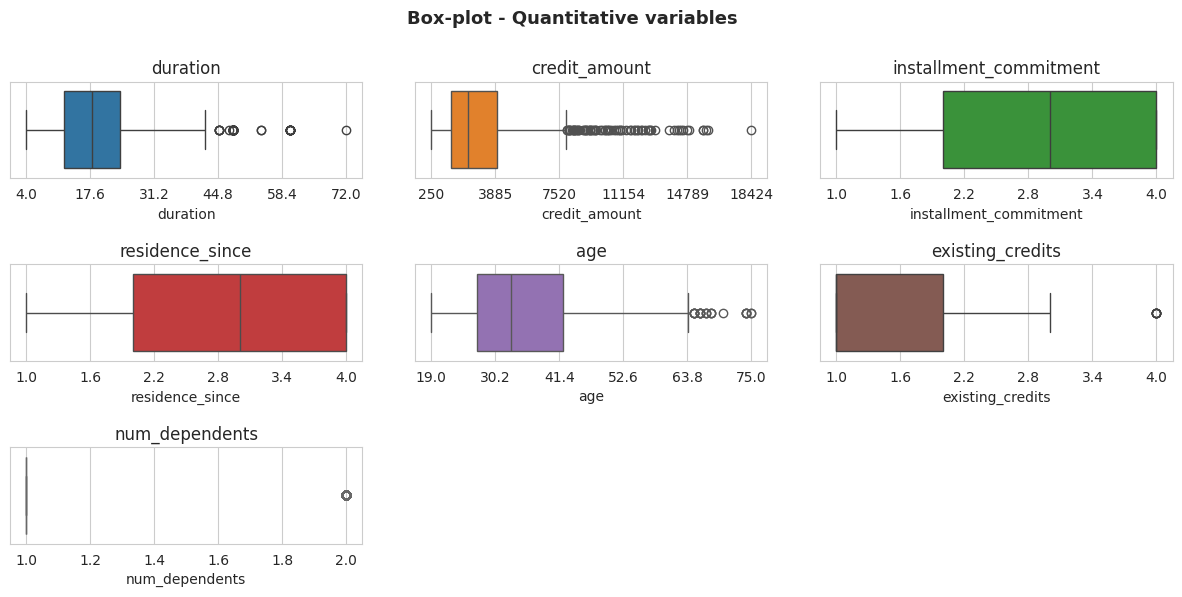

In [39]:
# Boxplot after outliers contamination
boxplot_matrix(X, 
               n_cols=3, 
               title='Box-plot - Quantitative variables', 
               figsize=(15,6), 
               quant_col_names=quant_predictors, 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=1,
               style='whitegrid', 
               hspace=0.9, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

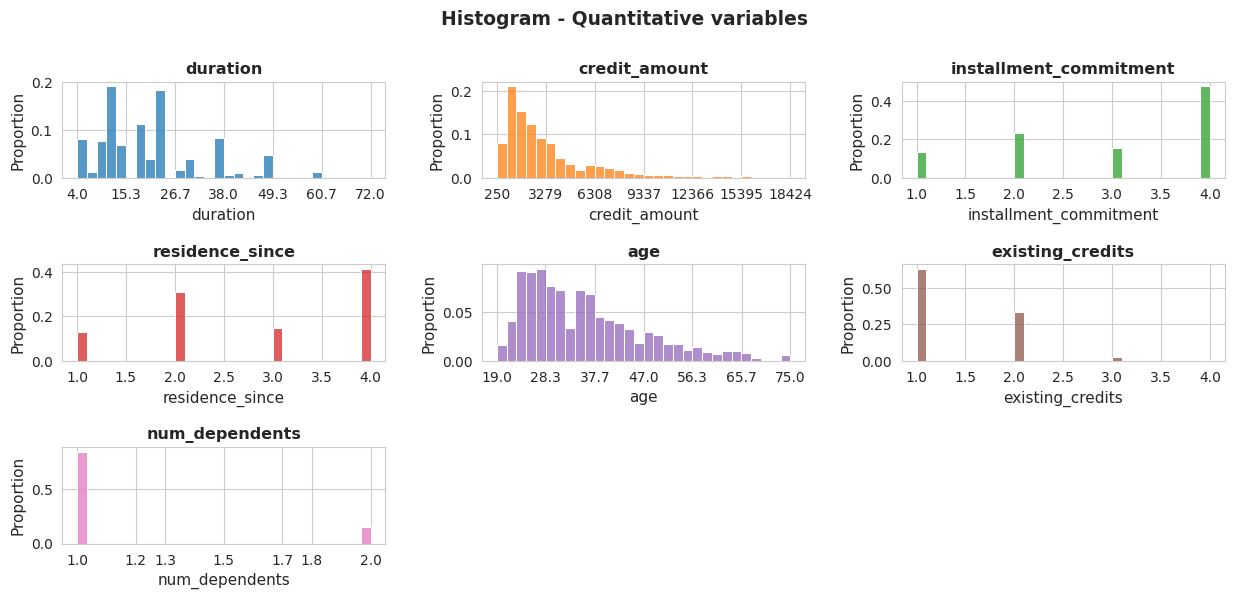

In [49]:
# Histogram
histogram_matrix(df=X, 
                 bins=30, 
                 n_cols=3, 
                 title='Histogram - Quantitative variables', 
                 figsize=(15,6), 
                 quant_col_names=quant_predictors, 
                 n_xticks=7, 
                 title_fontsize=13.5, 
                 subtitles_fontsize=11.5, 
                 save=False, 
                 file_name='', 
                 x_rotation=0, 
                 title_height=1,
                 style='whitegrid', 
                 hspace=0.9, 
                 wspace=0.3, 
                 n_round_xticks=1)

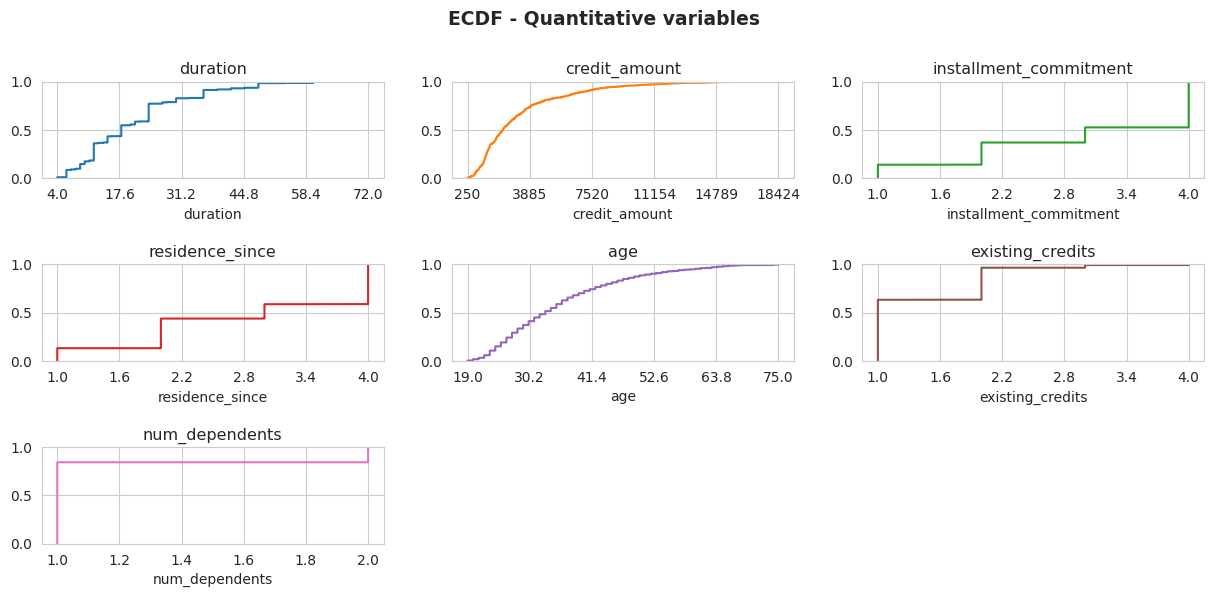

In [58]:
ecdfplot_matrix(df=X, 
                n_cols=3, 
                title='ECDF - Quantitative variables', 
                complementary=False, 
                figsize=(15,6), 
                auto_col=False, 
                quant_col_names=quant_predictors, 
                title_weight='bold',
                n_xticks=6, 
                title_fontsize=13.5, 
                subtitles_fontsize=11.5, 
                save=False, 
                file_name=None, 
                random=False, 
                n=None, 
                fraction=None, 
                seed=123, 
                x_rotation=0, 
                title_height=1,
                style='whitegrid', 
                hspace=0.9, 
                wspace=0.2,
                n_round_xticks=2, 
                xlabel_size=10) 

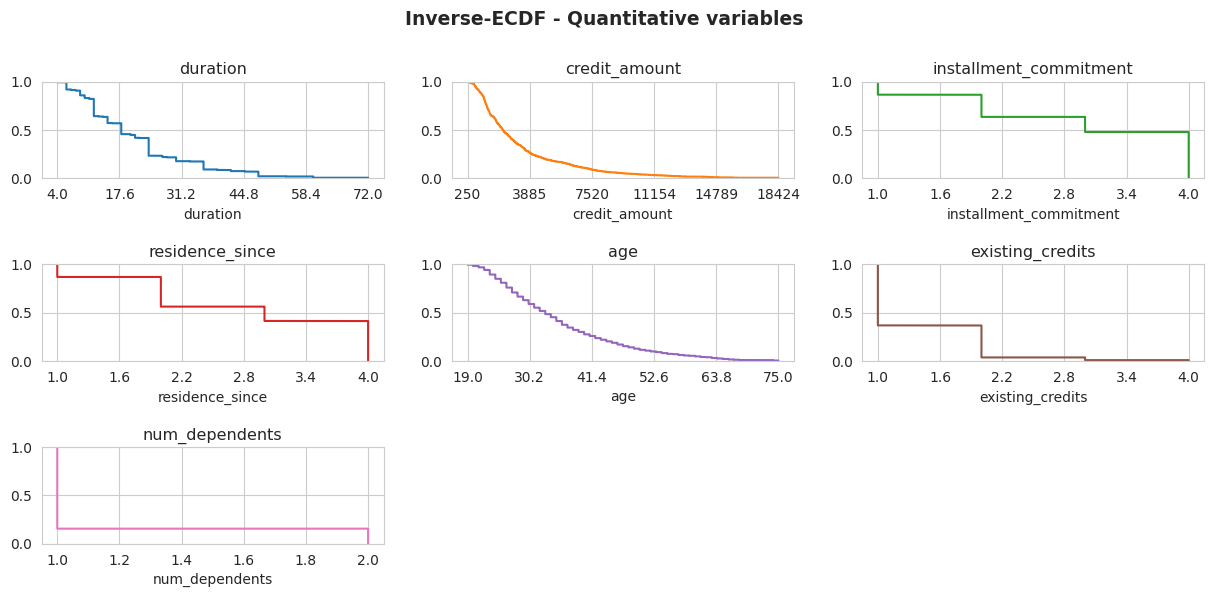

In [57]:
ecdfplot_matrix(df=X, 
                n_cols=3, 
                title='Inverse-ECDF - Quantitative variables', 
                complementary=True, 
                figsize=(15,6), 
                auto_col=False, 
                quant_col_names=quant_predictors, 
                title_weight='bold',
                n_xticks=6, 
                title_fontsize=13.5, 
                subtitles_fontsize=11.5, 
                save=False, 
                file_name=None, 
                random=False, 
                n=None, 
                fraction=None, 
                seed=123, 
                x_rotation=0, 
                title_height=1,
                style='whitegrid', 
                hspace=0.9, 
                wspace=0.2,
                n_round_xticks=2, 
                xlabel_size=10) 

In [ ]:
# Barplot
barplot_matrix(df=X, 
               n_cols=2, 
               title='Barplot - Categorical variables', 
               figsize=(8,4), 
               cat_col_names=['X5', 'X6', 'X7', 'X8'], 
               title_fontsize=13, 
               subtitles_fontsize=11, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.75, 
               wspace=0.4, 
               title_weight='bold', 
               bar_width=0.35,
               ylabel_size=10, 
               xlabel_size=9, 
               xticks_size=10)

In [ ]:
# Correlation Matrix
X.corr()

In [ ]:
# Correlation Analysis
corr_matrix = X.corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))


## Experiment 1



## Experiment 3



## Experiment 4